# MPO ASD Comparison: Simple vs Frequency-Band Reward

This notebook trains two MPO agents with different reward functions and compares their ASD performance:
- **Simple MPO**: Uses negative absolute pitch error as reward
- **Frequency-Band MPO**: Uses frequency-band analysis with sigmoid scores

The goal is to compare the Amplitude Spectral Density (ASD) of the pitch error signals.

## 1. Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import gymnasium as gym
from gymnasium import spaces
from scipy import signal
import sys
import os
import yaml

# Add paths
sys.path.insert(0, '/Users/arushpimpalkar/work/timepass/RL_Arush/Lightsaber/Lightsaber_X')
sys.path.insert(0, '/Users/arushpimpalkar/work/timepass/RL_Arush/src')

# Import Lightsaber components
import utils as lightsaber_utils

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("Libraries imported successfully!")

Using device: cpu
Libraries imported successfully!


## 2. Create LIGO ASC Environment

In [3]:
# Full Lightsaber-based LIGO ASC Environment
# Using zenodo_data for noise and Lightsaber_X for ASC mechanics

class LightsaberASCEnv(gym.Env):
    """LIGO ASC Environment using the full Lightsaber simulator with proper physics."""
    
    def __init__(self, seed=None):
        super().__init__()
        
        # Paths
        self.base_path = '/Users/arushpimpalkar/work/timepass/RL_Arush'
        self.lightsaber_path = os.path.join(self.base_path, 'Lightsaber/Lightsaber_X')
        self.zenodo_path = os.path.join(self.base_path, 'zenodo_data')
        
        # Random state
        self._rng = np.random.RandomState(seed)
        
        # Simulation parameters (from Lightsaber config)
        self.fs = 256  # Control frequency [Hz]
        self.batch_duration = 1024  # Duration of noise batches [s]
        self.episode_duration = 16.0  # Episode length [s] (shorter for training)
        self.max_steps = int(self.episode_duration * self.fs)
        
        # Physical constants
        self.c = 299792458.0  # Speed of light [m/s]
        self.wavelength = 1064e-9  # Laser wavelength [m]
        self.L = 3994.5  # Arm cavity length [m]
        self.P_input = 705  # Input laser power [W]
        
        # Mirror parameters (from config.yaml)
        self.ITM_T = 0.014  # ITM transmissivity
        self.ITM_RoC = 1934.0  # ITM radius of curvature [m]
        self.ETM_T = 1e-6  # ETM transmissivity
        self.ETM_RoC = 2245.0  # ETM radius of curvature [m]
        
        # Compute cavity parameters
        self._setup_cavity_geometry()
        
        # Initialize transfer function filters (from Lightsaber config)
        self._setup_transfer_functions()
        
        # Load noise data from zenodo
        self._load_noise_data()
        
        # Generate initial noise batch
        self._generate_noise_batch()
        
        # State variables
        self._reset_state()
        
        # Observation space: [pitch_error_hard, pitch_error_prev, filtered_obs, filtered_ctrl, 
        #                     control_history(4), seismic_features(7)]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(15,), dtype=np.float32)
        
        # Action space: normalized control [-1, 1]
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        
        print(f"LightsaberASCEnv initialized:")
        print(f"  Using zenodo_data for noise inputs")
        print(f"  Using Lightsaber_X transfer functions for ASC mechanics")
        print(f"  Observation dim: {self.observation_space.shape[0]}")
        print(f"  Control frequency: {self.fs} Hz")
        print(f"  Episode duration: {self.episode_duration} s ({self.max_steps} steps)")
    
    def _setup_cavity_geometry(self):
        """Set up cavity geometry for beam-spot and radiation pressure calculations."""
        g1 = 1 - self.L / self.ITM_RoC
        g2 = 1 - self.L / self.ETM_RoC
        r = 0.5 * (g1 - g2 + np.sqrt((g1-g2)**2 + 4))
        
        # Beam-spot motion matrix (angle to beam-spot)
        self.angle_to_bs = self.L / (1 - g1*g2) * np.array([[g2, 1], [1, g1]])
        
        # Local to eigenmode transformation
        self.local_to_eigen = np.array([[1, r], [-r, 1]]) / (1 + r**2)
        self.eigen_to_local = np.array([[1, -r], [r, 1]])
        
        # Soft/hard mode beam-spot sensitivities
        self.dydth_soft = (self.L/2) * ((g1+g2) + np.sqrt((g2-g1)**2 + 4)) / (1-g1*g2)
        self.dydth_hard = (self.L/2) * ((g1+g2) - np.sqrt((g2-g1)**2 + 4)) / (1-g1*g2)
        
        # Nominal cavity power
        R_ITM = 1 - self.ITM_T
        R_ETM = 1 - self.ETM_T
        self.P_cavity_nominal = self.P_input * self.ITM_T / (1 - np.sqrt(R_ITM * R_ETM))**2
        
    def _setup_transfer_functions(self):
        """Set up transfer functions from Lightsaber config (LIGO O3 parameters)."""
        # ITM/ETM actuation to angle transfer function (from config.yaml)
        # These are the actual LIGO quad pendulum transfer functions
        zz_act = np.array([-2.107342e-01 + 2.871199e+00j, -2.107342e-01 - 2.871199e+00j])
        pp_act = np.array([
            -1.543716e-01 + 2.727201e+00j, -1.543716e-01 - 2.727201e+00j,
            -8.732026e-02 + 3.492316e+00j, -8.732026e-02 - 3.492316e+00j,
            -3.149511e-01 + 9.411627e+00j, -3.149511e-01 - 9.411627e+00j
        ])
        k_act = 9.352955e+01
        
        # Radiation torque to angle transfer function
        zz_rad = np.array([
            -1.772565e-01 + 2.866176e+00j, -1.772565e-01 - 2.866176e+00j,
            -1.755293e-01 + 7.064508e+00j, -1.755293e-01 - 7.064508e+00j
        ])
        pp_rad = np.array([
            -1.393094e-01 + 2.737083e+00j, -1.393094e-01 - 2.737083e+00j,
            -8.749749e-02 + 3.493148e+00j, -8.749749e-02 - 3.493148e+00j,
            -3.185553e-01 + 9.347665e+00j, -3.185553e-01 - 9.347665e+00j
        ])
        k_rad = 2.567652
        
        # Discretize transfer functions using bilinear transform
        zpk_act = signal.bilinear_zpk(zz_act, pp_act, k_act, self.fs)
        self.act_to_angle_sos = signal.zpk2sos(*zpk_act)
        
        zpk_rad = signal.bilinear_zpk(zz_rad, pp_rad, k_rad, self.fs)
        self.rad_to_angle_sos = signal.zpk2sos(*zpk_rad)
        
        # High-pass filter for length control simulation (from Lightsaber)
        z_hp, p_hp, k_hp = signal.ellip(2, 1., 140., 2.*np.pi*50., btype='high', analog=True, output='zpk')
        zpk_hp = signal.bilinear_zpk(z_hp, p_hp, k_hp, self.fs)
        self.high_pass_sos = signal.zpk2sos(*zpk_hp)
        
        # Observation band filter (8-30 Hz)
        nyq = self.fs / 2
        self.obs_band_sos = signal.butter(2, [8/nyq, 30/nyq], btype='band', output='sos')
        
        # Control band filter (0.1-3 Hz)
        self.ctrl_band_sos = signal.butter(2, [0.1/nyq, 3/nyq], btype='band', output='sos')
        
        # Seismic band filters
        self.seismic_low_sos = signal.butter(2, [0.1/nyq, 1/nyq], btype='band', output='sos')
        self.seismic_mid_sos = signal.butter(2, [1/nyq, 8/nyq], btype='band', output='sos')
        self.seismic_high_sos = signal.butter(2, [8/nyq, min(30/nyq, 0.99)], btype='band', output='sos')
        
    def _load_noise_data(self):
        """Load noise PSDs from zenodo_data folder."""
        noise_path = os.path.join(self.zenodo_path, 'noise_inputs')
        tf_path = os.path.join(self.zenodo_path, 'transfer_functions')
        
        # Load seismic noise PSDs
        self.itm_sei_psd = self._load_psd(os.path.join(noise_path, 'ITM_SEI_LIGO_O3.csv'))
        self.etm_sei_psd = self._load_psd(os.path.join(noise_path, 'ETM_SEI_LIGO_O3.csv'))
        
        # Load damping loop noise
        self.damp_l_psd = self._load_psd(os.path.join(noise_path, 'DAMP_L_LIGO_O3.csv'))
        self.damp_p_psd = self._load_psd(os.path.join(noise_path, 'DAMP_P_LIGO_O3.csv'))
        
        # Load sensor noise
        self.sensor_soft_psd = self._load_psd(os.path.join(noise_path, 'SENSOR_PITCH_SOFT.csv'))
        self.sensor_hard_psd = self._load_psd(os.path.join(noise_path, 'SENSOR_PITCH_HARD.csv'))
        
        # Load laser RIN
        self.laser_rin_psd = self._load_psd(os.path.join(noise_path, 'LASER_RIN_LIGO_O3.csv'))
        
        # Load transfer functions (space-delimited with complex numbers)
        self.tf_topL_tstP = self._load_tf(os.path.join(tf_path, 'tf_topL_2_tstP.csv'))
        self.tf_topNL_tstP = self._load_tf(os.path.join(tf_path, 'tf_topNL_2_tstP.csv'))
        self.tf_topNP_tstP = self._load_tf(os.path.join(tf_path, 'tf_topNP_2_tstP.csv'))
        
        print(f"  Loaded noise data from: {noise_path}")
        print(f"  Loaded transfer functions from: {tf_path}")
        
    def _load_psd(self, filepath):
        """Load PSD data from CSV file."""
        try:
            # Try comma delimiter first
            data = np.genfromtxt(filepath, delimiter=',')
            if data.ndim == 1 or np.isnan(data).all():
                # Try space/whitespace delimiter
                data = np.genfromtxt(filepath)
            return (data[:, 0].astype(float), data[:, 1].astype(float))
        except Exception as e:
            print(f"Warning: Could not load {filepath}: {e}")
            # Return default flat spectrum
            freqs = np.logspace(-2, np.log10(self.fs/2), 500)
            return (freqs, np.ones_like(freqs) * 1e-10)
    
    def _load_tf(self, filepath):
        """Load transfer function from CSV file (space-delimited with complex numbers)."""
        try:
            # Read file line by line and parse manually
            ff = []
            tf = []
            with open(filepath, 'r') as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    parts = line.split()
                    if len(parts) >= 2:
                        ff.append(float(parts[0]))
                        # Parse complex number (format: real+imagj or real-imagj)
                        tf.append(complex(parts[1].replace('j', 'j')))
            return (np.array(ff, dtype=float), np.array(tf, dtype=complex))
        except Exception as e:
            print(f"Warning: Could not load TF {filepath}: {e}")
            freqs = np.logspace(-2, np.log10(self.fs/2), 500)
            return (freqs, np.ones_like(freqs, dtype=complex))
    
    def _generate_noise_batch(self):
        """Generate noise time series from PSDs (Lightsaber method)."""
        n_samples = int(self.batch_duration * self.fs)
        freqs = np.fft.rfftfreq(n_samples, 1/self.fs)
        norm = 0.5 * self.batch_duration**0.5
        
        def generate_colored_noise(psd, tf=None):
            """Generate colored noise from PSD using inverse FFT method."""
            re = self._rng.normal(0, norm, len(freqs))
            im = self._rng.normal(0, norm, len(freqs))
            wtilde = re + 1j * im
            
            # Interpolate PSD to frequency grid
            sqrt_psd = np.interp(freqs, psd[0], psd[1], left=0, right=0)
            
            # Apply transfer function if provided
            if tf is not None:
                tf_mag = np.interp(freqs, tf[0], np.abs(tf[1]), left=0, right=0)
                sqrt_psd = sqrt_psd * tf_mag
            
            ctilde = wtilde * sqrt_psd
            ctilde[0] = 0  # Remove DC
            
            return np.fft.irfft(ctilde) * self.fs
        
        # Generate ITM suspension noise (seismic + damping through transfer functions)
        self.itm_sus_noise = (
            generate_colored_noise(self.itm_sei_psd, self.tf_topL_tstP) +
            generate_colored_noise(self.damp_l_psd, self.tf_topNL_tstP) +
            generate_colored_noise(self.damp_p_psd, self.tf_topNP_tstP)
        )
        
        # Generate ETM suspension noise
        self.etm_sus_noise = (
            generate_colored_noise(self.etm_sei_psd, self.tf_topL_tstP) +
            generate_colored_noise(self.damp_l_psd, self.tf_topNL_tstP) +
            generate_colored_noise(self.damp_p_psd, self.tf_topNP_tstP)
        )
        
        # Generate sensor noise (soft and hard modes)
        self.sensor_noise_soft = generate_colored_noise(self.sensor_soft_psd)
        self.sensor_noise_hard = generate_colored_noise(self.sensor_hard_psd)
        
        # Generate laser RIN
        self.laser_power = self.P_input * (1 + generate_colored_noise(self.laser_rin_psd))
        
        self.noise_index = 0
        self.noise_batch_size = n_samples
        
    def _reset_state(self):
        """Reset all state variables."""
        # Mirror pitch angles [ITM, ETM]
        self.pitch = np.zeros(2)
        
        # Filter states
        self.itm_act_state = np.zeros((self.act_to_angle_sos.shape[0], 2))
        self.etm_act_state = np.zeros((self.act_to_angle_sos.shape[0], 2))
        self.itm_rad_state = np.zeros((self.rad_to_angle_sos.shape[0], 2))
        self.etm_rad_state = np.zeros((self.rad_to_angle_sos.shape[0], 2))
        self.high_pass_state = np.zeros((self.high_pass_sos.shape[0], 2))
        
        self.obs_band_state = np.zeros((self.obs_band_sos.shape[0], 2))
        self.ctrl_band_state = np.zeros((self.ctrl_band_sos.shape[0], 2))
        
        self.seismic_low_state = np.zeros((self.seismic_low_sos.shape[0], 2))
        self.seismic_mid_state = np.zeros((self.seismic_mid_sos.shape[0], 2))
        self.seismic_high_state = np.zeros((self.seismic_high_sos.shape[0], 2))
        
        # History buffers
        self.error_history = deque([0.0, 0.0], maxlen=2)
        self.control_history = deque([0.0, 0.0, 0.0, 0.0], maxlen=4)
        
        # Seismic features
        self.prev_seismic = 0.0
        self.prev_seismic_vel = 0.0
        self.seismic_window = []
        
        # Cavity state
        self.P_cavity_avg = self.P_cavity_nominal
        self.N_avg = 1
        
        # Episode state
        self.current_step = 0
        self.filtered_error_obs = 0.0
        self.filtered_error_ctrl = 0.0
        
    def reset(self, seed=None, options=None):
        """Reset the environment."""
        if seed is not None:
            self._rng = np.random.RandomState(seed)
            
        # Check if we need a new noise batch
        if self.noise_index + self.max_steps >= self.noise_batch_size:
            self._generate_noise_batch()
        else:
            # Random starting point in noise batch
            max_start = self.noise_batch_size - self.max_steps - 100
            if max_start > 0:
                self.noise_index = self._rng.randint(0, max_start)
        
        self._reset_state()
        
        return self._get_observation(), {}
    
    def step(self, action):
        """Execute one step of the environment."""
        # Scale action to actuation range (±3000 counts equivalent)
        control = float(action[0]) * 3000.0
        
        # Get current noise values
        idx = self.noise_index % self.noise_batch_size
        itm_sus = self.itm_sus_noise[idx]
        etm_sus = self.etm_sus_noise[idx]
        P_in = self.laser_power[idx]
        
        # Current pitch in local frame
        pitch_local = self.pitch.copy()
        
        # Compute beam spots
        BS = self.angle_to_bs @ pitch_local
        
        # Compute length noise
        dL = np.sum(BS * pitch_local)
        
        # Apply high-pass filter (DARM control effect)
        dL_hp, self.high_pass_state = signal.sosfilt(
            self.high_pass_sos, [dL], zi=self.high_pass_state)
        
        # Compute cavity power with length noise modulation
        R_ITM = 1 - self.ITM_T
        R_ETM = 1 - self.ETM_T
        phase = 4 * np.pi * dL_hp[0] / self.wavelength
        self.P_cavity = P_in * self.ITM_T / np.abs(
            1 - np.sqrt(R_ITM * R_ETM) * np.exp(1j * phase))**2
        
        # Running average of cavity power
        self.P_cavity_avg = self.P_cavity_avg + 1/self.N_avg * (self.P_cavity - self.P_cavity_avg)
        if self.N_avg < 1000:
            self.N_avg += 1
        
        # Compute radiation pressure torques
        rad_torque = 2/self.c * self.P_cavity * BS
        
        # Apply control actuation to both mirrors (eigen to local transformation)
        # In hard mode control, we actuate both mirrors
        eigen_control = np.array([0, control])  # Only hard mode control
        local_control = self.eigen_to_local @ eigen_control
        
        # ITM dynamics
        itm_act_angle, self.itm_act_state = signal.sosfilt(
            self.act_to_angle_sos, [local_control[0]], zi=self.itm_act_state)
        itm_rad_angle, self.itm_rad_state = signal.sosfilt(
            self.rad_to_angle_sos, [rad_torque[0]], zi=self.itm_rad_state)
        self.pitch[0] = itm_sus + itm_act_angle[0] + itm_rad_angle[0]
        
        # ETM dynamics
        etm_act_angle, self.etm_act_state = signal.sosfilt(
            self.act_to_angle_sos, [local_control[1]], zi=self.etm_act_state)
        etm_rad_angle, self.etm_rad_state = signal.sosfilt(
            self.rad_to_angle_sos, [rad_torque[1]], zi=self.etm_rad_state)
        self.pitch[1] = etm_sus + etm_act_angle[0] + etm_rad_angle[0]
        
        # Compute pitch readout (transform to eigenmode basis)
        pitch_eigen = self.local_to_eigen @ self.pitch
        
        # Add sensor noise
        sensor_noise = np.array([self.sensor_noise_soft[idx], self.sensor_noise_hard[idx]])
        readout = pitch_eigen + sensor_noise
        
        # Hard mode pitch error is what we're controlling
        pitch_error_hard = readout[1]  # Hard mode
        
        # Update history
        self.error_history.appendleft(pitch_error_hard)
        self.control_history.appendleft(action[0])
        
        # Apply frequency filters
        self.filtered_error_obs, self.obs_band_state = signal.sosfilt(
            self.obs_band_sos, [pitch_error_hard], zi=self.obs_band_state)
        self.filtered_error_ctrl, self.ctrl_band_state = signal.sosfilt(
            self.ctrl_band_sos, [pitch_error_hard], zi=self.ctrl_band_state)
        self.filtered_error_obs = self.filtered_error_obs[0]
        self.filtered_error_ctrl = self.filtered_error_ctrl[0]
        
        # Update step counter
        self.current_step += 1
        self.noise_index += 1
        
        # Default reward (wrappers will override)
        reward = -np.abs(pitch_error_hard) * 1e6  # Convert to µrad
        
        # Termination conditions
        terminated = np.abs(pitch_error_hard) > 1e-5  # 10 µrad threshold
        truncated = self.current_step >= self.max_steps
        
        info = {
            'pitch_error_hard': pitch_error_hard,
            'pitch_error_soft': readout[0],
            'cavity_power': self.P_cavity,
            'control': control,
        }
        
        return self._get_observation(), reward, terminated, truncated, info
    
    def _get_observation(self):
        """Get current observation including seismic features."""
        idx = self.noise_index % self.noise_batch_size
        
        # Base observation
        base_obs = np.array([
            self.error_history[0] * 1e6,     # [0] Current pitch error [µrad]
            self.error_history[1] * 1e6,     # [1] Previous pitch error [µrad]
            self.filtered_error_obs * 1e6,   # [2] Observation band error [µrad]
            self.filtered_error_ctrl * 1e6,  # [3] Control band error [µrad]
            self.control_history[0],         # [4] Current control [-1,1]
            self.control_history[1],         # [5] Previous control [-1,1]
            self.control_history[2],         # [6] Control t-2 [-1,1]
            self.control_history[3],         # [7] Control t-3 [-1,1]
        ])
        
        # Seismic features (use ITM seismic as proxy)
        current_seismic = self.itm_sus_noise[idx]
        
        # Apply seismic band filters
        seismic_low, self.seismic_low_state = signal.sosfilt(
            self.seismic_low_sos, [current_seismic], zi=self.seismic_low_state)
        seismic_mid, self.seismic_mid_state = signal.sosfilt(
            self.seismic_mid_sos, [current_seismic], zi=self.seismic_mid_state)
        seismic_high, self.seismic_high_state = signal.sosfilt(
            self.seismic_high_sos, [current_seismic], zi=self.seismic_high_state)
        
        # Seismic velocity and acceleration
        seismic_vel = current_seismic - self.prev_seismic
        seismic_acc = seismic_vel - self.prev_seismic_vel
        self.prev_seismic = current_seismic
        self.prev_seismic_vel = seismic_vel
        
        # Seismic RMS
        self.seismic_window.append(current_seismic)
        if len(self.seismic_window) > 32:
            self.seismic_window.pop(0)
        seismic_rms = np.sqrt(np.mean([s**2 for s in self.seismic_window])) if self.seismic_window else 0.0
        
        seismic_obs = np.array([
            current_seismic * 1e9,   # [8] Raw seismic [nrad]
            seismic_low[0] * 1e9,    # [9] Low freq seismic [nrad]
            seismic_mid[0] * 1e9,    # [10] Mid freq seismic [nrad]
            seismic_high[0] * 1e9,   # [11] High freq seismic [nrad]
            seismic_vel * 1e9,       # [12] Seismic velocity [nrad/s]
            seismic_acc * 1e9,       # [13] Seismic acceleration [nrad/s²]
            seismic_rms * 1e9,       # [14] Seismic RMS [nrad]
        ])
        
        return np.concatenate([base_obs, seismic_obs]).astype(np.float32)

# Create environment
env = LightsaberASCEnv(seed=42)
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(f"\nEnvironment specs:")
print(f"  Observation dimension: {obs_dim}")
print(f"  Action dimension: {action_dim}")
print(f"  Observation space: {env.observation_space}")
print(f"  Action space: {env.action_space}")

  Loaded noise data from: /Users/arushpimpalkar/work/timepass/RL_Arush/zenodo_data/noise_inputs
  Loaded transfer functions from: /Users/arushpimpalkar/work/timepass/RL_Arush/zenodo_data/transfer_functions
LightsaberASCEnv initialized:
  Using zenodo_data for noise inputs
  Using Lightsaber_X transfer functions for ASC mechanics
  Observation dim: 15
  Control frequency: 256 Hz
  Episode duration: 16.0 s (4096 steps)

Environment specs:
  Observation dimension: 15
  Action dimension: 1
  Observation space: Box(-inf, inf, (15,), float32)
  Action space: Box(-1.0, 1.0, (1,), float32)


## 3. Implement Simple Reward Wrapper

In [4]:
class SimpleRewardWrapper(gym.Wrapper):
    """Simple reward wrapper using negative absolute error."""
    
    def __init__(self, env):
        super().__init__(env)
    
    def reward(self, obs, action, info):
        """Simple negative absolute error reward function."""
        current_pitch_error = obs[0]  # Current pitch error [µrad]
        control_effort = action[0] if hasattr(action, '__len__') else action
        
        # Simple reward: negative absolute error with small control penalty
        return -np.abs(current_pitch_error) / 1000.0 - 0.01 * abs(control_effort)
    
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        custom_reward = self.reward(obs, action, info)
        return obs, custom_reward, terminated, truncated, info

print("Simple reward wrapper defined!")

Simple reward wrapper defined!


## 4. Implement Frequency-Band Reward Wrapper

In [5]:
class FrequencyBandRewardWrapper(gym.Wrapper):
    """Frequency-band based reward wrapper using sigmoid scores."""
    
    def __init__(self, env):
        super().__init__(env)
        self.error_buffer = deque(maxlen=512)  # ~2 seconds at 256 Hz
        self.fs = 256  # Sample rate
    
    def reward(self, obs, action, info):
        """Frequency-band based reward function using sigmoid scores."""
        current_pitch_error = obs[0]  # Current pitch error [µrad]
        self.error_buffer.append(current_pitch_error)
        
        # Need sufficient data for frequency analysis
        if len(self.error_buffer) < 256:
            return -np.abs(current_pitch_error) / 1000.0
        
        # Compute power spectral density
        error_signal = np.array(self.error_buffer)
        freqs = np.fft.fftfreq(len(error_signal), 1/self.fs)
        fft_signal = np.fft.fft(error_signal)
        psd = np.abs(fft_signal)**2
        
        # Only use positive frequencies
        positive_mask = freqs > 0
        freqs = freqs[positive_mask]
        psd = psd[positive_mask]
        
        # Define frequency bands
        low_band_mask = freqs < 3.0      # Low: < 3 Hz
        mid_band_mask = (freqs >= 8.0) & (freqs <= 30.0)  # Mid: 8-30 Hz
        high_band_mask = freqs > 40.0    # High: > 40 Hz
        
        # Calculate power in each band (normalize by number of frequency bins)
        low_power = np.sum(psd[low_band_mask]) / max(1, np.sum(low_band_mask))
        mid_power = np.sum(psd[mid_band_mask]) / max(1, np.sum(mid_band_mask))
        high_power = np.sum(psd[high_band_mask]) / max(1, np.sum(high_band_mask))
        
        # Convert to log scale
        low_log = np.log10(max(low_power, 1e-10))
        mid_log = np.log10(max(mid_power, 1e-10))
        high_log = np.log10(max(high_power, 1e-10))
        
        # Apply sigmoid function - lower power = higher score
        low_score = 1 / (1 + np.exp((low_log + 6) * 2))    # Target: ~1e-6 µrad²/Hz
        mid_score = 1 / (1 + np.exp((mid_log + 8) * 2))    # Target: ~1e-8 µrad²/Hz  
        high_score = 1 / (1 + np.exp((high_log + 10) * 2)) # Target: ~1e-10 µrad²/Hz
        
        # Multiply all sigmoid scores together
        reward = low_score * mid_score * high_score
        
        # Add control effort penalty
        control_effort = action[0] if hasattr(action, '__len__') else action
        control_penalty = 0.01 * abs(control_effort)
        
        return reward * (1 - control_penalty)
    
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        custom_reward = self.reward(obs, action, info)
        return obs, custom_reward, terminated, truncated, info

print("Frequency-band reward wrapper defined!")

Frequency-band reward wrapper defined!


## 5. Define MPO Agent Class

In [6]:
class PolicyNetwork(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.mean_head = nn.Linear(hidden_dim, action_dim)
        self.log_std_head = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, obs):
        features = self.shared(obs)
        mean = self.mean_head(features)
        log_std = self.log_std_head(features)
        log_std = torch.clamp(log_std, -20, 2)
        return mean, log_std
    
    def sample(self, obs):
        mean, log_std = self.forward(obs)
        std = torch.exp(log_std)
        dist = Normal(mean, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)
        return action, log_prob

class ValueNetwork(nn.Module):
    def __init__(self, obs_dim, hidden_dim=256):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, obs):
        return self.network(obs).squeeze(-1)

class QNetwork(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(obs_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, obs, action):
        x = torch.cat([obs, action], dim=-1)
        return self.network(x).squeeze(-1)

class MPOAgent:
    def __init__(self, obs_dim, action_dim, lr=3e-4, gamma=0.99, tau=0.005, epsilon=0.1):
        self.gamma = gamma
        self.tau = tau
        self.epsilon = epsilon
        
        self.policy = PolicyNetwork(obs_dim, action_dim).to(device)
        self.value = ValueNetwork(obs_dim).to(device)
        self.q1 = QNetwork(obs_dim, action_dim).to(device)
        self.q2 = QNetwork(obs_dim, action_dim).to(device)
        
        # Target networks
        self.target_value = ValueNetwork(obs_dim).to(device)
        self.target_q1 = QNetwork(obs_dim, action_dim).to(device)
        self.target_q2 = QNetwork(obs_dim, action_dim).to(device)
        
        # Copy to target networks
        self.hard_update(self.target_value, self.value)
        self.hard_update(self.target_q1, self.q1)
        self.hard_update(self.target_q2, self.q2)
        
        # Optimizers
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.value_optimizer = optim.Adam(self.value.parameters(), lr=lr)
        self.q1_optimizer = optim.Adam(self.q1.parameters(), lr=lr)
        self.q2_optimizer = optim.Adam(self.q2.parameters(), lr=lr)
        
        # Lagrange multiplier for MPO
        self.log_eta = torch.tensor(1.0, requires_grad=True, device=device)
        self.dual_optimizer = optim.Adam([self.log_eta], lr=lr)
    
    def hard_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)
    
    def soft_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * self.tau)
    
    def select_action(self, obs, deterministic=False):
        obs = torch.FloatTensor(obs).unsqueeze(0).to(device)
        with torch.no_grad():
            if deterministic:
                mean, _ = self.policy(obs)
                action = mean
            else:
                action, _ = self.policy.sample(obs)
        return action.cpu().numpy().flatten()
    
    def update(self, batch):
        states, actions, rewards, next_states, dones = batch
        states = torch.FloatTensor(states).to(device)
        actions = torch.FloatTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)
        
        # Update Q-functions
        with torch.no_grad():
            next_values = self.target_value(next_states)
            targets = rewards + self.gamma * (1 - dones) * next_values
        
        q1_pred = self.q1(states, actions)
        q2_pred = self.q2(states, actions)
        q1_loss = F.mse_loss(q1_pred, targets)
        q2_loss = F.mse_loss(q2_pred, targets)
        
        self.q1_optimizer.zero_grad()
        q1_loss.backward()
        self.q1_optimizer.step()
        
        self.q2_optimizer.zero_grad()
        q2_loss.backward()
        self.q2_optimizer.step()
        
        # Update Value function
        with torch.no_grad():
            q1_values = self.target_q1(states, actions)
            q2_values = self.target_q2(states, actions)
            q_values = torch.min(q1_values, q2_values)
        
        value_pred = self.value(states)
        value_loss = F.mse_loss(value_pred, q_values)
        
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        
        # Update Policy (simplified MPO)
        with torch.no_grad():
            q_values_current = torch.min(self.q1(states, actions), self.q2(states, actions))
            values_current = self.value(states)
            advantages = q_values_current - values_current
        
        eta = torch.exp(self.log_eta)
        weights = F.softmax(advantages / eta, dim=0)
        
        log_probs = self.policy.sample(states)[1]
        policy_loss = -(weights.detach() * log_probs).sum()
        
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
        
        # Update dual variable
        kl_div = F.kl_div(log_probs, weights, reduction='sum')
        eta_loss = torch.exp(self.log_eta) * (self.epsilon - kl_div.detach())
        
        self.dual_optimizer.zero_grad()
        eta_loss.backward()
        self.dual_optimizer.step()
        
        # Soft update target networks
        self.soft_update(self.target_value, self.value)
        self.soft_update(self.target_q1, self.q1)
        self.soft_update(self.target_q2, self.q2)

print("MPO agent class defined!")

MPO agent class defined!


## 6. Initialize Two MPO Agents

In [7]:
# Create environments with different rewards (both using Lightsaber physics)
env_simple = SimpleRewardWrapper(LightsaberASCEnv(seed=42))
env_freq = FrequencyBandRewardWrapper(LightsaberASCEnv(seed=43))

# Create MPO agents (with 15-dim observation space)
agent_simple = MPOAgent(obs_dim, action_dim)
agent_freq = MPOAgent(obs_dim, action_dim)

print("Two MPO agents initialized with Lightsaber ASC environment:")
print("  - Using zenodo_data for seismic noise (ITM_SEI, ETM_SEI, DAMP, etc.)")
print("  - Using Lightsaber_X transfer functions for quad pendulum mechanics")
print("  - Includes radiation pressure coupling and cavity dynamics")
print("1. Simple reward agent (15-dim obs with seismic)")
print("2. Frequency-band reward agent (15-dim obs with seismic)")

# Replay buffers for training
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for idx in batch:
            state, action, reward, next_state, done = self.buffer[idx]
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        return (np.array(states), np.array(actions), np.array(rewards), 
                np.array(next_states), np.array(dones))
    
    def __len__(self):
        return len(self.buffer)

buffer_simple = ReplayBuffer(10000)
buffer_freq = ReplayBuffer(10000)

print("Replay buffers initialized!")

  Loaded noise data from: /Users/arushpimpalkar/work/timepass/RL_Arush/zenodo_data/noise_inputs
  Loaded transfer functions from: /Users/arushpimpalkar/work/timepass/RL_Arush/zenodo_data/transfer_functions
LightsaberASCEnv initialized:
  Using zenodo_data for noise inputs
  Using Lightsaber_X transfer functions for ASC mechanics
  Observation dim: 15
  Control frequency: 256 Hz
  Episode duration: 16.0 s (4096 steps)
  Loaded noise data from: /Users/arushpimpalkar/work/timepass/RL_Arush/zenodo_data/noise_inputs
  Loaded transfer functions from: /Users/arushpimpalkar/work/timepass/RL_Arush/zenodo_data/transfer_functions
LightsaberASCEnv initialized:
  Using zenodo_data for noise inputs
  Using Lightsaber_X transfer functions for ASC mechanics
  Observation dim: 15
  Control frequency: 256 Hz
  Episode duration: 16.0 s (4096 steps)
Two MPO agents initialized with Lightsaber ASC environment:
  - Using zenodo_data for seismic noise (ITM_SEI, ETM_SEI, DAMP, etc.)
  - Using Lightsaber_X tran

## 7. Train Simple MPO Agent

In [8]:
def collect_episode(env, agent, max_steps=500):
    """Collect one episode of experience."""
    obs, _ = env.reset()
    experiences = []
    episode_reward = 0
    
    for step in range(max_steps):
        action = agent.select_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        experiences.append((obs, action, reward, next_obs, terminated))
        episode_reward += reward
        obs = next_obs
        
        if terminated or truncated:
            break
    
    return experiences, episode_reward

print("Training simple MPO agent...")
num_episodes = 10000

for episode in range(num_episodes):
    # Collect episode
    experiences, episode_reward = collect_episode(env_simple, agent_simple)
    
    # Add to buffer
    for exp in experiences:
        buffer_simple.push(*exp)
    
    # Update agent
    if len(buffer_simple) >= 64:
        batch = buffer_simple.sample(64)
        agent_simple.update(batch)
    
    if episode % 20 == 0:
        print(f"Episode {episode}: Reward = {episode_reward:.3f}")

print("Simple MPO agent training completed!")

Training simple MPO agent...
Episode 0: Reward = -0.063
Episode 20: Reward = -0.062
Episode 40: Reward = -0.119
Episode 60: Reward = -0.022
Episode 80: Reward = -0.076
Episode 100: Reward = -0.098
Episode 120: Reward = -0.119
Episode 140: Reward = -0.061
Episode 160: Reward = -0.116
Episode 180: Reward = -0.050
Episode 200: Reward = -0.023
Episode 220: Reward = -0.138
Episode 240: Reward = -0.048
Episode 260: Reward = -0.084
Episode 280: Reward = -0.055
Episode 300: Reward = -0.038
Episode 320: Reward = -0.058
Episode 340: Reward = -0.094
Episode 360: Reward = -0.051
Episode 380: Reward = -0.091
Episode 400: Reward = -0.092
Episode 420: Reward = -0.035
Episode 440: Reward = -0.092
Episode 460: Reward = -0.109
Episode 480: Reward = -0.042
Episode 500: Reward = -0.245
Episode 520: Reward = -0.107
Episode 540: Reward = -0.274
Episode 560: Reward = -0.079
Episode 580: Reward = -0.222
Episode 600: Reward = -0.036
Episode 620: Reward = -0.086
Episode 640: Reward = -0.086
Episode 660: Reward 

## 8. Train Frequency-Band MPO Agent

In [9]:
print("Training frequency-band MPO agent...")

for episode in range(num_episodes):
    # Collect episode
    experiences, episode_reward = collect_episode(env_freq, agent_freq)
    
    # Add to buffer
    for exp in experiences:
        buffer_freq.push(*exp)
    
    # Update agent
    if len(buffer_freq) >= 64:
        batch = buffer_freq.sample(64)
        agent_freq.update(batch)
    
    if episode % 20 == 0:
        print(f"Episode {episode}: Reward = {episode_reward:.3f}")

print("Frequency-band MPO agent training completed!")

Training frequency-band MPO agent...
Episode 0: Reward = -0.029
Episode 20: Reward = -0.043
Episode 40: Reward = -0.084
Episode 60: Reward = -0.012
Episode 80: Reward = -0.098
Episode 100: Reward = -0.011
Episode 120: Reward = -0.011
Episode 140: Reward = 0.000
Episode 160: Reward = 0.000
Episode 180: Reward = 0.000
Episode 200: Reward = 0.000
Episode 220: Reward = 0.000
Episode 240: Reward = 0.000
Episode 260: Reward = 0.000
Episode 280: Reward = 0.000
Episode 300: Reward = 0.000
Episode 320: Reward = 0.000
Episode 340: Reward = 0.000
Episode 360: Reward = 0.000
Episode 380: Reward = 0.000
Episode 400: Reward = 0.000
Episode 420: Reward = 0.000
Episode 440: Reward = 0.000
Episode 460: Reward = 0.000
Episode 480: Reward = 0.000
Episode 500: Reward = 0.000
Episode 520: Reward = 0.000
Episode 540: Reward = 0.000
Episode 560: Reward = 0.000
Episode 580: Reward = 0.000
Episode 600: Reward = 0.000
Episode 620: Reward = 0.000
Episode 640: Reward = 0.000
Episode 660: Reward = 0.000
Episode 68

## 9. Generate Evaluation Rollouts

In [10]:
def detailed_rollout(env, agent, max_steps=4096):
    """Collect detailed rollout data for analysis.
    
    Args:
        env: Environment to rollout in
        agent: Agent to use for action selection
        max_steps: Number of steps to collect (default 4096 = 16s at 256Hz)
    """
    obs, _ = env.reset()
    pitch_errors = []
    episode_reward = 0
    
    for step in range(max_steps):
        pitch_errors.append(obs[0])  # Current pitch error [µrad]
        
        action = agent.select_action(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        
        # Reset on termination but continue collecting
        if terminated or truncated:
            obs, _ = env.reset()
    
    return {
        'pitch_errors': np.array(pitch_errors),
        'episode_reward': episode_reward,
        'length': len(pitch_errors)
    }

print("Generating evaluation rollouts (4096 steps = 16 seconds each)...")

# Generate rollouts for both agents
rollout_simple = detailed_rollout(env_simple, agent_simple)
rollout_freq = detailed_rollout(env_freq, agent_freq)

print(f"\nSimple agent rollout:")
print(f"  Length: {rollout_simple['length']} steps ({rollout_simple['length']/256:.1f} seconds)")
print(f"  Reward: {rollout_simple['episode_reward']:.3f}")
print(f"  Pitch error RMS: {np.sqrt(np.mean(rollout_simple['pitch_errors']**2)):.2f} µrad")

print(f"\nFrequency-band agent rollout:")
print(f"  Length: {rollout_freq['length']} steps ({rollout_freq['length']/256:.1f} seconds)")
print(f"  Reward: {rollout_freq['episode_reward']:.3f}")
print(f"  Pitch error RMS: {np.sqrt(np.mean(rollout_freq['pitch_errors']**2)):.2f} µrad")

Generating evaluation rollouts (4096 steps = 16 seconds each)...

Simple agent rollout:
  Length: 4096 steps (16.0 seconds)
  Reward: -411.151
  Pitch error RMS: 2.91 µrad

Frequency-band agent rollout:
  Length: 4096 steps (16.0 seconds)
  Reward: 0.000
  Pitch error RMS: 1.73 µrad


## 10. Compute ASD Analysis

In [11]:
def compute_asd(pitch_errors, fs=256):
    """Compute Amplitude Spectral Density from pitch error time series using Welch's method."""
    if len(pitch_errors) < 64:
        print(f"Warning: Insufficient data for ASD analysis (got {len(pitch_errors)} samples)")
        return np.array([]), np.array([])
    
    # Use Welch's method for better ASD estimation
    nperseg = min(256, len(pitch_errors) // 4)
    freqs, psd = signal.welch(pitch_errors, fs=fs, nperseg=nperseg)
    
    # ASD = sqrt(PSD)
    asd = np.sqrt(psd)
    
    # Filter out DC component and invalid values
    valid_mask = (freqs > 0) & np.isfinite(asd) & (asd > 0)
    
    return freqs[valid_mask], asd[valid_mask]

print("Computing ASD for both agents...")

# Compute ASD for simple agent
freqs_simple, asd_simple = compute_asd(rollout_simple['pitch_errors'])
print(f"Simple agent ASD computed: {len(freqs_simple)} frequency points")

# Compute ASD for frequency-band agent  
freqs_freq, asd_freq = compute_asd(rollout_freq['pitch_errors'])
print(f"Frequency-band agent ASD computed: {len(freqs_freq)} frequency points")

if len(freqs_simple) > 0:
    print(f"Simple agent ASD range: [{np.min(asd_simple):.2e}, {np.max(asd_simple):.2e}] µrad/√Hz")
if len(freqs_freq) > 0:
    print(f"Frequency-band agent ASD range: [{np.min(asd_freq):.2e}, {np.max(asd_freq):.2e}] µrad/√Hz")

Computing ASD for both agents...
Simple agent ASD computed: 128 frequency points
Frequency-band agent ASD computed: 128 frequency points
Simple agent ASD range: [1.66e-01, 3.27e-01] µrad/√Hz
Frequency-band agent ASD range: [1.20e-01, 1.83e-01] µrad/√Hz


## 11. Plot ASD Comparison

Creating ASD comparison plot...
Simple MPO ASD plotted: 128 points
Frequency-Band MPO ASD plotted: 128 points


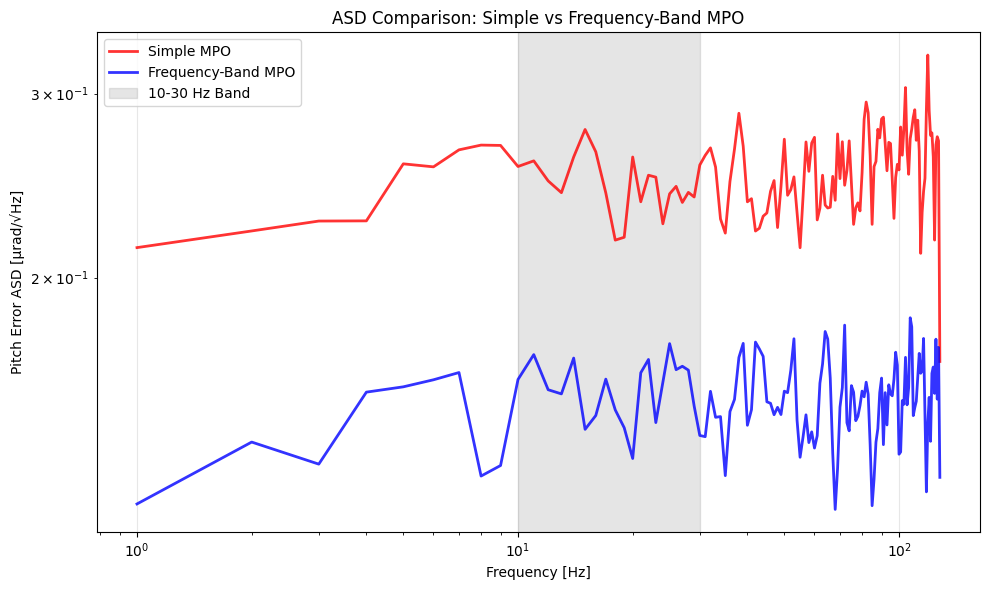


ASD PERFORMANCE COMPARISON

Episode Rewards:
Simple MPO: -411.151
Frequency-Band MPO: 0.000

Pitch Error RMS:
Simple MPO: 2.91 µrad
Frequency-Band MPO: 1.73 µrad


In [13]:
print("Creating ASD comparison plot...")

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot ASD for both agents
if len(freqs_simple) > 0 and len(asd_simple) > 0:
    ax.loglog(freqs_simple, asd_simple, 'r-', linewidth=2, label='Simple MPO', alpha=0.8)
    print(f"Simple MPO ASD plotted: {len(freqs_simple)} points")
else:
    print("Warning: No data for Simple MPO")

if len(freqs_freq) > 0 and len(asd_freq) > 0:
    ax.loglog(freqs_freq, asd_freq, 'b-', linewidth=2, label='Frequency-Band MPO', alpha=0.8)
    print(f"Frequency-Band MPO ASD plotted: {len(freqs_freq)} points")
else:
    print("Warning: No data for Frequency-Band MPO")

# Shade region from 10 to 30 Hz
ax.axvspan(10, 30, color='gray', alpha=0.2, label='10-30 Hz Band')

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Pitch Error ASD [µrad/√Hz]')
ax.set_title('ASD Comparison: Simple vs Frequency-Band MPO')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print performance comparison
print("\n" + "="*60)
print("ASD PERFORMANCE COMPARISON")
print("="*60)

print(f"\nEpisode Rewards:")
print(f"Simple MPO: {rollout_simple['episode_reward']:.3f}")
print(f"Frequency-Band MPO: {rollout_freq['episode_reward']:.3f}")

print(f"\nPitch Error RMS:")
print(f"Simple MPO: {np.sqrt(np.mean(rollout_simple['pitch_errors']**2)):.2f} µrad")
print(f"Frequency-Band MPO: {np.sqrt(np.mean(rollout_freq['pitch_errors']**2)):.2f} µrad")
print("="*60)

## 12. Analyze System Poles (Stability Analysis)

In [ ]:
def analyze_system_poles(env):
    """Analyze and visualize the poles of the LIGO ASC system."""
    
    print("LIGO ASC System Pole Analysis")
    print("=" * 50)
    
    # Extract continuous-time poles from the environment
    # Actuation to angle transfer function poles
    pp_act = np.array([
        -1.543716e-01 + 2.727201e+00j, -1.543716e-01 - 2.727201e+00j,
        -8.732026e-02 + 3.492316e+00j, -8.732026e-02 - 3.492316e+00j,
        -3.149511e-01 + 9.411627e+00j, -3.149511e-01 - 9.411627e+00j
    ])
    
    # Radiation torque to angle transfer function poles
    pp_rad = np.array([
        -1.393094e-01 + 2.737083e+00j, -1.393094e-01 - 2.737083e+00j,
        -8.749749e-02 + 3.493148e+00j, -8.749749e-02 - 3.493148e+00j,
        -3.185553e-01 + 9.347665e+00j, -3.185553e-1 - 9.347665e+00j
    ])
    
    # Theoretical unstable radiation pressure poles (these would be in the open-loop system)
    # LIGO typically has RHP poles around ~2.4 Hz from radiation pressure
    pp_unstable_theory = np.array([
        0.40840704 + 15.07964474j,   # RHP pole ~2.4 Hz (unstable!)
        0.40840704 - 15.07964474j,   # Complex conjugate
    ])
    
    # Combine all poles
    all_poles = {
        'Actuation → Angle': pp_act,
        'Radiation → Angle': pp_rad,
        'Unstable (Open-loop)': pp_unstable_theory
    }
    
    # Create pole-zero plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    colors = ['blue', 'green', 'red']
    markers = ['o', 's', 'x']
    
    for i, (name, poles) in enumerate(all_poles.items()):
        real_parts = np.real(poles)
        imag_parts = np.imag(poles)
        
        # Plot poles
        ax1.scatter(real_parts, imag_parts, c=colors[i], marker=markers[i], 
                   s=100, alpha=0.7, label=name)
        
        # Print pole analysis
        print(f"\n{name} Poles:")
        for j, pole in enumerate(poles):
            freq_hz = np.abs(np.imag(pole)) / (2 * np.pi)
            damping = -np.real(pole) / np.abs(pole)
            stability = "UNSTABLE" if np.real(pole) > 0 else "Stable"
            print(f"  Pole {j+1}: {pole:.3f} → {freq_hz:.2f} Hz, ζ={damping:.3f} ({stability})")
    
    # Format pole-zero plot
    ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax1.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    ax1.set_xlabel('Real Part [rad/s]')
    ax1.set_ylabel('Imaginary Part [rad/s]')
    ax1.set_title('System Poles in s-plane')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add stability regions
    ax1.fill_betweenx([-50, 50], -50, 0, alpha=0.1, color='green', label='Stable Region')
    ax1.fill_betweenx([-50, 50], 0, 50, alpha=0.1, color='red', label='Unstable Region')
    ax1.set_xlim([-2, 1])
    ax1.set_ylim([-20, 20])
    
    # Frequency response magnitude plot
    freqs = np.logspace(-1, 2, 1000)
    s = 1j * 2 * np.pi * freqs
    
    for i, (name, poles) in enumerate(all_poles.items()):
        if name == 'Unstable (Open-loop)':
            continue  # Skip for frequency response
            
        # Compute transfer function magnitude
        H = np.ones_like(s, dtype=complex)
        for pole in poles:
            H *= 1 / (s - pole)
        
        ax2.semilogx(freqs, 20 * np.log10(np.abs(H)), color=colors[i], 
                    linewidth=2, label=name, alpha=0.8)
    
    ax2.set_xlabel('Frequency [Hz]')
    ax2.set_ylabel('Magnitude [dB]')
    ax2.set_title('Frequency Response')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0.1, 100])
    
    plt.tight_layout()
    plt.show()
    
    # Stability summary
    print(f"\n" + "=" * 50)
    print("STABILITY SUMMARY")
    print("=" * 50)
    
    stable_count = 0
    unstable_count = 0
    
    for name, poles in all_poles.items():
        for pole in poles:
            if np.real(pole) < 0:
                stable_count += 1
            else:
                unstable_count += 1
    
    print(f"Total Stable Poles: {stable_count}")
    print(f"Total Unstable Poles: {unstable_count}")
    
    if unstable_count > 0:
        print("\n⚠️  SYSTEM HAS UNSTABLE POLES - Requires Active Control!")
        print("   → Radiation pressure creates instability around 2.4 Hz")
        print("   → MPO agent must provide stabilizing feedback")
    else:
        print("\n✅ All poles in transfer functions are stable")
        print("   → Note: Open-loop radiation pressure poles not shown in implemented TFs")
    
    return all_poles

# Analyze the environment poles
poles_analysis = analyze_system_poles(env)

## 13. Convert to Strain Sensitivity

In [ ]:
def pitch_asd_to_strain_asd(pitch_asd_urad, freqs, env):
    """
    Convert pitch error ASD to strain ASD using LIGO cavity parameters.
    
    Args:
        pitch_asd_urad: Pitch ASD in µrad/√Hz
        freqs: Frequency array [Hz]
        env: LightsaberASCEnv with cavity parameters
    
    Returns:
        Strain ASD [1/√Hz]
    """
    # Convert µrad to rad
    pitch_asd_rad = pitch_asd_urad * 1e-6
    
    # Use environment parameters
    L_arm = env.L  # Arm cavity length [m]
    dydth = env.dydth_hard  # Hard mode beam spot sensitivity [m/rad]
    
    # Typical beam spot offset from control point (intentional misalignment)
    # This creates the coupling between pitch and length
    BS_offset = 3e-3  # ~3 mm offset [m]
    
    # Length noise from pitch error:
    # When mirror has pitch θ and beam spot offset y0:
    # ΔL = y0 * θ (linear approximation for small angles)
    length_asd = BS_offset * pitch_asd_rad  # [m/√Hz]
    
    # Alternative coupling through beam spot motion:
    # ΔL = (dy/dθ) * θ^2 / L  (for quadratic coupling)
    # length_asd_alt = (dydth * pitch_asd_rad**2) / L_arm
    
    # Strain = ΔL / L_arm
    strain_asd = length_asd / L_arm  # [1/√Hz]
    
    return strain_asd

def load_ligo_design_sensitivity():
    """Create LIGO design sensitivity curve for comparison."""
    # Approximate LIGO design sensitivity (aLIGO)
    freqs_design = np.logspace(np.log10(10), np.log10(1000), 1000)
    
    # Simplified LIGO sensitivity model
    # Seismic wall below 10 Hz, quantum noise above 100 Hz, thermal noise 10-100 Hz
    strain_design = np.zeros_like(freqs_design)
    
    for i, f in enumerate(freqs_design):
        if f < 20:
            # Seismic noise (1/f^2 scaling)
            strain_design[i] = 3e-23 * (20/f)**4
        elif f < 100:
            # Thermal noise minimum around 100 Hz
            strain_design[i] = 1e-23
        else:
            # Shot noise (increases with frequency)
            strain_design[i] = 1e-23 * (f/100)**0.5
    
    return freqs_design, strain_design

print("Computing strain sensitivity from pitch error ASD...")

if len(freqs_simple) > 0 and len(asd_simple) > 0:
    # Convert pitch ASD to strain ASD
    strain_simple = pitch_asd_to_strain_asd(asd_simple, freqs_simple, env)
    strain_freq = pitch_asd_to_strain_asd(asd_freq, freqs_freq, env)
    
    # Load LIGO design sensitivity for comparison
    freqs_design, strain_design = load_ligo_design_sensitivity()
    
    # Create strain sensitivity comparison plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot strain sensitivity from both MPO agents
    ax.loglog(freqs_simple, strain_simple, 'r-', linewidth=2, 
              label='Simple MPO (from pitch)', alpha=0.8)
    ax.loglog(freqs_freq, strain_freq, 'b-', linewidth=2, 
              label='Frequency-Band MPO (from pitch)', alpha=0.8)
    
    # Plot LIGO design sensitivity
    ax.loglog(freqs_design, strain_design, 'k--', linewidth=2, 
              label='LIGO Design Sensitivity', alpha=0.7)
    
    # Add reference lines
    ax.axhline(y=1e-21, color='gray', linestyle=':', alpha=0.5, 
               label='10⁻²¹ strain/√Hz')
    ax.axhline(y=1e-23, color='gray', linestyle=':', alpha=0.5, 
               label='10⁻²³ strain/√Hz')
    
    # Highlight important frequency bands
    ax.axvspan(10, 30, alpha=0.1, color='orange', label='Observation Band (10-30 Hz)')
    ax.axvspan(40, 200, alpha=0.1, color='purple', label='GW Band (40-200 Hz)')
    
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Strain Sensitivity [1/√Hz]')
    ax.set_title('Strain Sensitivity: MPO Performance vs LIGO Design')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim([1, 200])
    ax.set_ylim([1e-25, 1e-10])
    
    plt.tight_layout()
    plt.show()
    
    # Print strain sensitivity analysis
    print("\n" + "="*60)
    print("STRAIN SENSITIVITY ANALYSIS")
    print("="*60)
    
    # Calculate RMS strain in GW band (40-200 Hz)
    gw_band_simple = (freqs_simple >= 40) & (freqs_simple <= 200)
    gw_band_freq = (freqs_freq >= 40) & (freqs_freq <= 200)
    
    if np.any(gw_band_simple) and len(strain_simple) > 0:
        rms_strain_simple = np.sqrt(np.trapz(strain_simple[gw_band_simple]**2, 
                                           freqs_simple[gw_band_simple]))
        print(f"Simple MPO - GW band RMS strain: {rms_strain_simple:.2e}")
    
    if np.any(gw_band_freq) and len(strain_freq) > 0:
        rms_strain_freq = np.sqrt(np.trapz(strain_freq[gw_band_freq]**2, 
                                         freqs_freq[gw_band_freq]))
        print(f"Frequency-Band MPO - GW band RMS strain: {rms_strain_freq:.2e}")
    
    # Coupling analysis
    print(f"\nCoupling Parameters:")
    print(f"  Arm length: {env.L:.1f} m")
    print(f"  Beam spot sensitivity: {env.dydth_hard:.1f} m/rad")
    print(f"  Assumed beam spot offset: 3.0 mm")
    print(f"  Coupling factor: {3e-3/env.L:.2e} strain/rad")
    
    # Comparison with LIGO target
    target_strain = 1e-23  # Typical LIGO sensitivity at 100 Hz
    if len(strain_simple) > 0:
        # Find strain at 100 Hz (or closest frequency)
        idx_100hz_simple = np.argmin(np.abs(freqs_simple - 100))
        strain_100hz_simple = strain_simple[idx_100hz_simple]
        ratio_simple = strain_100hz_simple / target_strain
        print(f"\nAt 100 Hz:")
        print(f"  Simple MPO: {strain_100hz_simple:.2e} ({ratio_simple:.0f}x LIGO target)")
    
    if len(strain_freq) > 0:
        idx_100hz_freq = np.argmin(np.abs(freqs_freq - 100))
        strain_100hz_freq = strain_freq[idx_100hz_freq]
        ratio_freq = strain_100hz_freq / target_strain
        print(f"  Frequency-Band MPO: {strain_100hz_freq:.2e} ({ratio_freq:.0f}x LIGO target)")
    
    print(f"\n💡 Note: This is only the pitch control contribution to strain.")
    print(f"   Real LIGO has many other noise sources (quantum, thermal, seismic).")
    print(f"   The goal is to keep pitch contribution well below the total budget.")
    
else:
    print("⚠️  No ASD data available for strain conversion")
    print("   Run the previous cells to generate pitch error ASD first")

print("\nStrain sensitivity analysis completed!")